In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [3]:
!rm -rf /kaggle/working/crypto_market_prediction
!git clone https://github.com/CapstoneTeam23UMICH/crypto_market_prediction.git

Cloning into 'crypto_market_prediction'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 75 (delta 25), reused 36 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 9.78 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import shap

import gc

sys.path.append('/kaggle/working/crypto_market_prediction')
from src.github_push_file import push_parquet_to_github
from src.get_refresh_metadata import get_feature_drift_df
from src.get_refresh_metadata import get_correlation_train_df
from src.get_refresh_metadata import get_correlation_test_df
from src.get_refresh_metadata import get_autocorrelation_train_df

In [9]:
df_drift = get_feature_drift_df()
df_corr_train = get_correlation_train_df()
df_autocorr = get_autocorrelation_train_df()

Loading existing df_feature_drift.parquet
Loading existing corr_long_train.parquet
Loading existing autocorr_long_train.parquet


In [10]:
train_path = '/kaggle/input/drw-crypto-market-prediction/train.parquet'
test_path = '/kaggle/input/drw-crypto-market-prediction/test.parquet'

df_train = pd.read_parquet(train_path).astype('float32')
df_test = pd.read_parquet(test_path).astype('float32')

In [11]:
known_features = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
target = 'label'
anonymized_features = sorted(list(set(df_train.columns) - set(known_features) - set([target])), key=lambda x: int(x[1:]))

In [12]:
low_drift_features = df_drift[df_drift['ks_abs'] < 0.2]['feature']

In [ ]:
adv_train = df_train[features].copy().astype('float32').fillna(0)
adv_test = df_test[features].copy().astype('float32').fillna(0)

adv_train['is_test'] = 0
adv_test['is_test'] = 1

adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[features]
y_adv = adv_data['is_test']

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_adv, y_adv, test_size=0.3, random_state=42, stratify=y_adv
)

clf = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    random_state=random_state
)
clf.fit(X_train_adv, y_train_adv)

y_pred_proba = clf.predict_proba(X_test_adv)[:, 1]
auc = roc_auc_score(y_test_adv, y_pred_proba)

print(f"Adversarial validation AUC: {auc:.4f}")

X_sample = X_adv.sample(n=100000, random_state=random_state)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)[1]
shap_importance = pd.DataFrame(shap_values, columns=X_sample.columns).abs().mean().sort_values(ascending=False)

importance = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)



In [45]:
pd.Series(clf.feature_importances_, index=low_drift_features).sort_values(ascending=False)

ValueError: Length of values (336) does not match length of index (686)

In [41]:
shap_importance

X285    0.270182
X499    0.259229
X415    0.238595
X547    0.188894
X150    0.188147
          ...   
X497    0.000000
X482    0.000000
X498    0.000000
X371    0.000000
X661    0.000000
Length: 480, dtype: float64

In [42]:
feature_data = {
    feature: {
        "shap_importance": float(shap_importance[feature]),
        "lgb_importance": int(clf.feature_importances_[i])
    }
    for i, feature in enumerate(shap_importance.index)
}

IndexError: index 336 is out of bounds for axis 0 with size 336

In [13]:
adv_train = df_train[low_drift_features].copy().astype('float32').fillna(0)
adv_test = df_test[low_drift_features].copy().astype('float32').fillna(0)
adv_train['is_test'] = 0
adv_test['is_test'] = 1
adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[low_drift_features]
y_adv = adv_data['is_test']

clf = lgb.LGBMClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
clf.fit(X_adv, y_adv)

LGBMClassifier(random_state=42, verbose=-1)

In [10]:
y_pred_proba = clf.predict_proba(X_adv)[:, 1]
auc = roc_auc_score(y_adv, y_pred_proba)
auc

0.9999760912428095

In [17]:
importance = pd.Series(clf.feature_importances_, index=low_drift_features).sort_values(ascending=False)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


X501    0.503762
X436    0.414883
X614    0.410385
X427    0.374308
X284    0.281247
X97     0.255556
X613    0.243632
X758    0.233612
X761    0.225987
X508    0.207287
X770    0.202910
X605    0.190995
X612    0.186179
X341    0.178564
X445    0.168042
X550    0.152708
X96     0.150566
X385    0.149526
X561    0.137936
X516    0.134252
dtype: float64


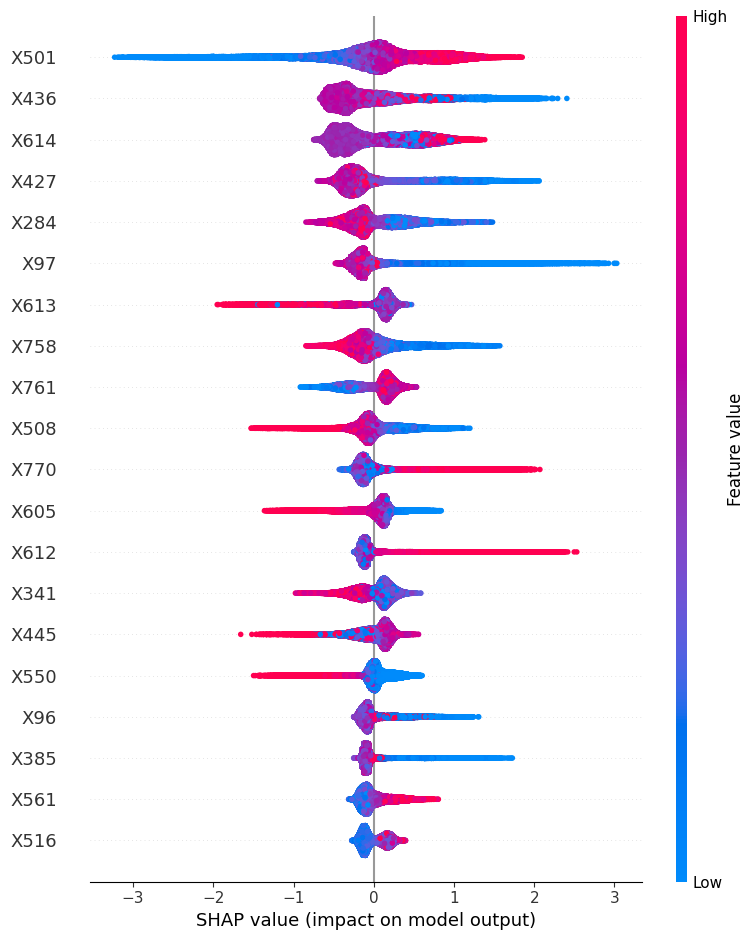

In [14]:
X_sample = X_adv.sample(n=100000, random_state=42)  # reduce if needed

# 4. Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)[1]  # [1] = class 'test'

# 5. Get mean absolute SHAP values as feature importance
shap_importance = pd.DataFrame(shap_values, columns=X_sample.columns).abs().mean().sort_values(ascending=False)

# 6. Output or visualize
print(shap_importance.head(20))  # top 20 most drifted features

# Optional: visualize summary plot
shap.summary_plot(shap_values, X_sample)

In [28]:
threshold = 0.7
stable_features = shap_importance[shap_importance < shap_importance.quantile(threshold)].index.tolist()

In [35]:
shap_importance[shap_importance==0]

X717    0.0
X660    0.0
X687    0.0
X699    0.0
X328    0.0
       ... 
X417    0.0
X375    0.0
X170    0.0
X128    0.0
X661    0.0
Length: 465, dtype: float64

In [29]:
adv_train = df_train[stable_features].copy().astype('float32').fillna(0)
adv_test = df_test[stable_features].copy().astype('float32').fillna(0)
adv_train['is_test'] = 0
adv_test['is_test'] = 1
adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[stable_features]
y_adv = adv_data['is_test']

clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
clf.fit(X_adv, y_adv)

y_pred_proba = clf.predict_proba(X_adv)[:, 1]
auc = roc_auc_score(y_adv, y_pred_proba)

print(auc)

0.9904967982979586


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


X285    0.270182
X499    0.259229
X415    0.238595
X547    0.188894
X150    0.188147
X127    0.171695
X404    0.162905
X556    0.161035
X377    0.149708
X609    0.147344
X616    0.146544
X596    0.126393
X506    0.125480
X458    0.124529
X108    0.119779
X36     0.119571
X419    0.111047
X682    0.107053
X578    0.092531
X618    0.091575
dtype: float64


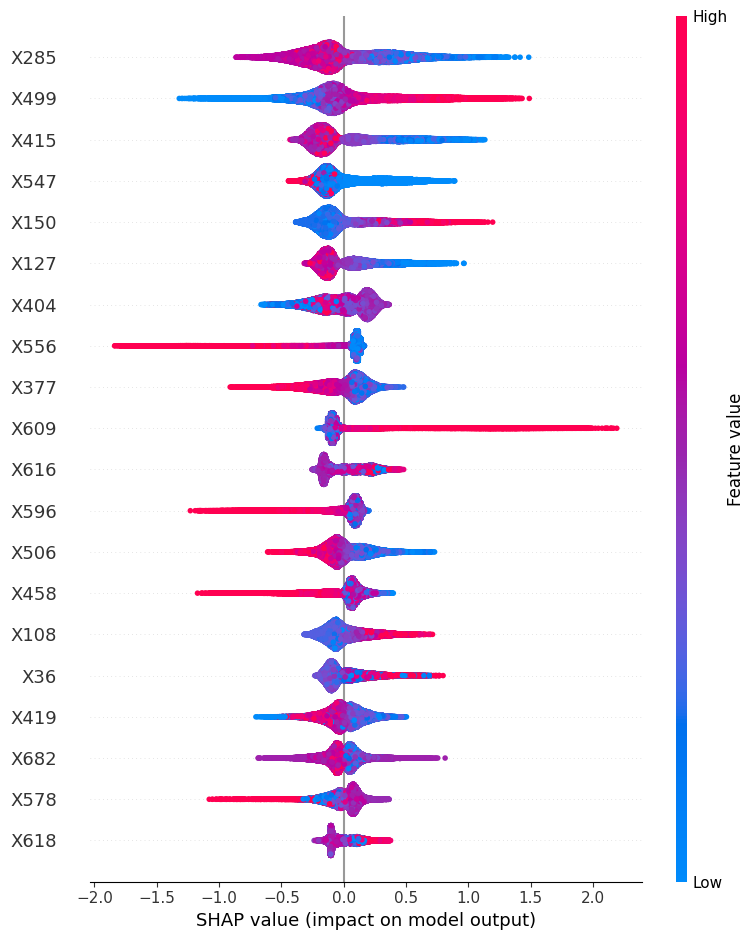

In [36]:
X_sample = X_adv.sample(n=100000, random_state=42)  # reduce if needed

# 4. Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)[1]  # [1] = class 'test'

# 5. Get mean absolute SHAP values as feature importance
shap_importance = pd.DataFrame(shap_values, columns=X_sample.columns).abs().mean().sort_values(ascending=False)

# 6. Output or visualize
print(shap_importance.head(20))  # top 20 most drifted features

# Optional: visualize summary plot
shap.summary_plot(shap_values, X_sample)

In [37]:
threshold = 0.7
stable_features = shap_importance[shap_importance < shap_importance.quantile(threshold)].index.tolist()

In [40]:
adv_train = df_train[stable_features].copy().astype('float32').fillna(0)
adv_test = df_test[stable_features].copy().astype('float32').fillna(0)
adv_train['is_test'] = 0
adv_test['is_test'] = 1
adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[stable_features]
y_adv = adv_data['is_test']

clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
clf.fit(X_adv, y_adv)

y_pred_proba = clf.predict_proba(X_adv)[:, 1]
auc = roc_auc_score(y_adv, y_pred_proba)

print(auc)

0.9515449405271719


In [32]:
adv_train = df_train[stable_features].copy().astype('float32').fillna(0)
adv_test = df_test[stable_features].copy().astype('float32').fillna(0)

adv_train['is_test'] = 0
adv_test['is_test'] = 1

adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[stable_features]
y_adv = adv_data['is_test']

# 2. Split into train/validation for adversarial classifier
X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    X_adv, y_adv, test_size=0.3, random_state=42, stratify=y_adv
)

# 3. Train adversarial classifier
clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
clf.fit(X_train_adv, y_train_adv)

# 4. Predict and calculate AUC on validation set
y_pred_proba = clf.predict_proba(X_val_adv)[:, 1]
auc = roc_auc_score(y_val_adv, y_pred_proba)

print(f"Adversarial validation AUC: {auc:.4f}")

Adversarial validation AUC: 0.9904


In [27]:
len(stable_features)

480

In [21]:
len(shap_importance)

686

In [26]:
threshold = 0.75
stable_features = importance[importance < importance.quantile(threshold)].index.tolist()

In [27]:
adv_train = df_train[stable_features].copy().astype('float32').fillna(0)
adv_test = df_test[stable_features].copy().astype('float32').fillna(0)
adv_train['is_test'] = 0
adv_test['is_test'] = 1
adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[stable_features]
y_adv = adv_data['is_test']

clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
clf.fit(X_adv, y_adv)

y_pred_proba = clf.predict_proba(X_adv)[:, 1]
auc = roc_auc_score(y_adv, y_pred_proba)

print(auc)

0.9992881883752479


In [30]:
importance['X431']

0

In [29]:
pd.Series(clf.feature_importances_, index=stable_features).sort_values(ascending=False)

X431    225
X53     155
X186    149
X567    110
X293    105
       ... 
X121      0
X119      0
X117      0
X116      0
X391      0
Length: 485, dtype: int32

In [ ]:
importance = pd.Series(clf.feature_importances_, index=features)
stable_features = importance[importance < importance.quantile(threshold)].index.tolist()
print(f"Adversarial validation: Keeping {len(stable_features)} stable features.")
del adv_train, adv_test, adv_data, X_adv, y_adv, clf
gc.collect()

In [ ]:
def adversarial_validation(df_train, df_test, features, threshold=0.7):
    adv_train = df_train[features].copy().astype('float32').fillna(0)
    adv_test = df_test[features].copy().astype('float32').fillna(0)
    adv_train['is_test'] = 0
    adv_test['is_test'] = 1
    adv_data = pd.concat([adv_train, adv_test], axis=0)
    X_adv = adv_data[features]
    y_adv = adv_data['is_test']
    
    clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    clf.fit(X_adv, y_adv)
    importance = pd.Series(clf.feature_importances_, index=features)
    stable_features = importance[importance < importance.quantile(threshold)].index.tolist()
    print(f"Adversarial validation: Keeping {len(stable_features)} stable features.")
    del adv_train, adv_test, adv_data, X_adv, y_adv, clf
    gc.collect()
    
    
    return stable_features

In [31]:
import shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


X772    10.339542
X445     0.168912
X586     0.168734
X773     0.102076
X582     0.055999
X710     0.022610
X588     0.019668
X444     0.010030
X592     0.007242
X750     0.007133
X95      0.006994
X576     0.006551
X464     0.003862
X583     0.003171
X3       0.002221
X141     0.002182
X644     0.002018
X23      0.001918
X564     0.001849
X386     0.001699
dtype: float64


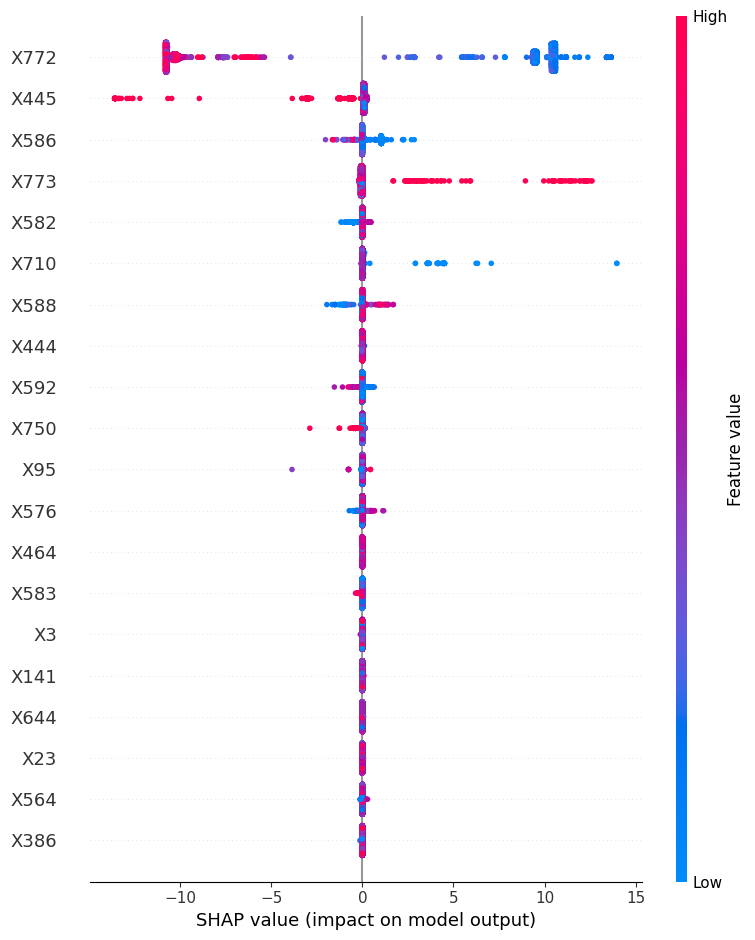

In [32]:
adv_train = df_train[anonymized_features].copy().astype('float32').fillna(0)
adv_test = df_test[anonymized_features].copy().astype('float32').fillna(0)
adv_train['is_test'] = 0
adv_test['is_test'] = 1

adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[anonymized_features]
y_adv = adv_data['is_test']

# 2. Fit Adversarial Classifier
clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
clf.fit(X_adv, y_adv)

# 3. Sample data for SHAP (optional but recommended for speed)
X_sample = X_adv.sample(n=50000, random_state=42)  # reduce if needed

# 4. Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)[1]  # [1] = class 'test'

# 5. Get mean absolute SHAP values as feature importance
shap_importance = pd.DataFrame(shap_values, columns=X_sample.columns).abs().mean().sort_values(ascending=False)

# 6. Output or visualize
print(shap_importance.head(20))  # top 20 most drifted features

# Optional: visualize summary plot
shap.summary_plot(shap_values, X_sample)

In [34]:
threshold = 0.5
stable_features = shap_importance[shap_importance < shap_importance.quantile(threshold)].index.tolist()

In [39]:
shap_importance.tail(50)

X239    0.0
X240    0.0
X241    0.0
X242    0.0
X243    0.0
X244    0.0
X245    0.0
X246    0.0
X248    0.0
X249    0.0
X275    0.0
X278    0.0
X349    0.0
X323    0.0
X315    0.0
X316    0.0
X317    0.0
X318    0.0
X320    0.0
X321    0.0
X322    0.0
X324    0.0
X281    0.0
X329    0.0
X336    0.0
X339    0.0
X345    0.0
X346    0.0
X347    0.0
X348    0.0
X314    0.0
X313    0.0
X312    0.0
X311    0.0
X282    0.0
X283    0.0
X284    0.0
X285    0.0
X287    0.0
X290    0.0
X291    0.0
X293    0.0
X304    0.0
X305    0.0
X306    0.0
X307    0.0
X308    0.0
X309    0.0
X310    0.0
X391    0.0
dtype: float64

In [50]:
adv_train = df_train[stable_features].copy().astype('float32').fillna(0)
adv_test = df_test[stable_features].copy().astype('float32').fillna(0)
adv_train['is_test'] = 0
adv_test['is_test'] = 1
adv_data = pd.concat([adv_train, adv_test], axis=0)
X_adv = adv_data[stable_features]
y_adv = adv_data['is_test']

clf = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
clf.fit(X_adv, y_adv)

y_pred_proba = clf.predict_proba(X_adv)[:, 1]
auc = roc_auc_score(y_adv, y_pred_proba)

print(auc)

0.989242615099533


In [45]:
threshold = 0.75
stable_features = shap_importance[shap_importance < shap_importance.quantile(threshold)].index.tolist()

In [49]:
len(shap_importance)

585

In [48]:
len(stable_features)

438

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


X567    0.968038
X540    0.668227
X301    0.626397
X53     0.613672
X186    0.563402
X431    0.525991
X614    0.213444
X335    0.202069
X296    0.168253
X556    0.163177
X139    0.161727
X458    0.136541
X498    0.135422
X549    0.120320
X233    0.117342
X97     0.115336
X506    0.096577
X428    0.094101
X178    0.093470
X451    0.092248
dtype: float64


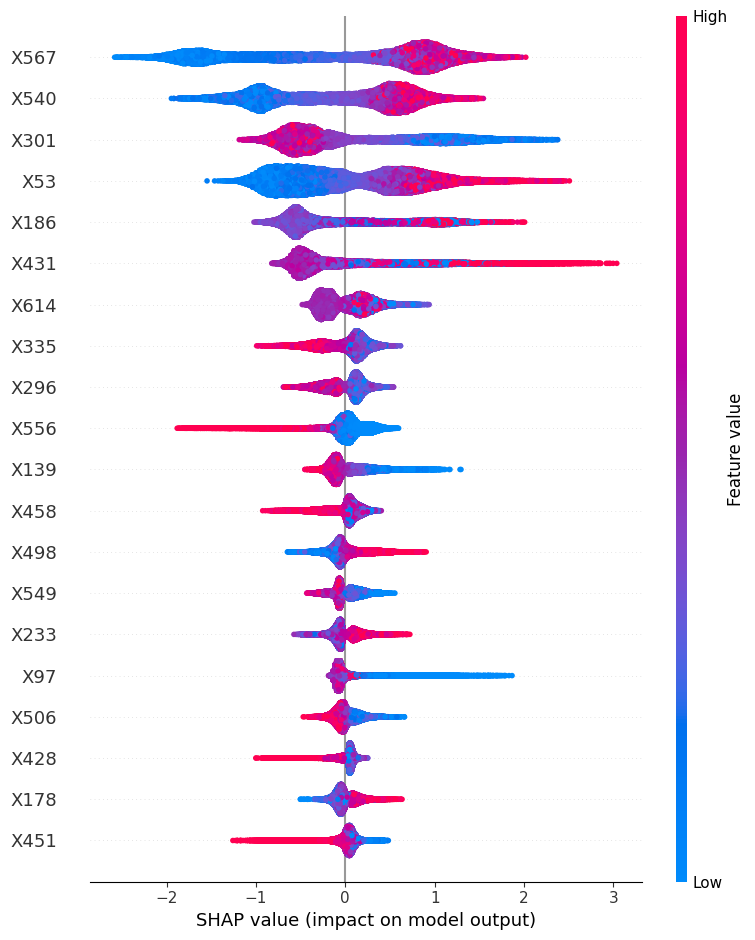

In [40]:
X_sample = X_adv.sample(n=100000, random_state=42)  # reduce if needed

# 4. Compute SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)[1]  # [1] = class 'test'

# 5. Get mean absolute SHAP values as feature importance
shap_importance = pd.DataFrame(shap_values, columns=X_sample.columns).abs().mean().sort_values(ascending=False)

# 6. Output or visualize
print(shap_importance.head(20))  # top 20 most drifted features

# Optional: visualize summary plot
shap.summary_plot(shap_values, X_sample)

In [36]:
pd.Series(clf.feature_importances_, index=stable_features).sort_values(ascending=False)

X431    186
X301    156
X53     154
X186    129
X567    110
       ... 
X663      0
X664      0
X665      0
X667      0
X391      0
Length: 585, dtype: int32

In [ ]:
def drop_features(data, df_corr_train, adversarial_drop):
    correlated_drop_features = set(df_corr_train[df_corr_train['corr'] > 0.98].y)
#    constant_features =
    
    

In [ ]:
def preprocess_and_create_features(data, known_features):
    
    for col in known_features:
        if col in data.columns:
            p1, p99 = data[col].quantile([0.01, 0.99])
            data[col] = data[col].clip(p1, p99)
            result_data[f'log_{col}'] = np.log1p(data[col].clip(lower=0)).astype('float32')
            result_data[f'{col}_sq'] = (data[col] ** 2).astype('float32')
            result_data[f'{col}_cube'] = (data[col] ** 3).astype('float32')
            result_data[f'{col}_sin'] = np.sin(data[col]).astype('float32')
            result_data[f'{col}_exp'] = np.exp(data[col].clip(upper=10)).astype('float32')
    
    result_data['buy_sell_ratio'] = (data['buy_qty'] / (data['sell_qty'] + 1e-6)).astype('float32')
    result_data['net_flow'] = (data['buy_qty'] - data['sell_qty']).astype('float32')
    result_data['order_imbalance'] = ((data['buy_qty'] - data['sell_qty']) / (data['buy_qty'] + data['sell_qty'] + 1e-6)).astype('float32')
    result_data['volume_imbalance'] = (data['volume'] * result_data['order_imbalance']).astype('float32')

    return result_data